In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import vice
from vice.yields.presets import JW20

In [8]:
# Star formation history functions
def g(rgal, rthin=2.5, rthick=2, sigma_ratio0=0.27):
    """
    Stellar surface density gradient as function of galactic radius.
    rgal : galactic radius in kpc
    rthin : scale radius of thin disc in kpc
    rthick : scale radius of thick disc in kpc
    sigma_ratio0 : ratio of thick / thin surface densities at rgal=0
    """
    return np.exp(-rgal/rthin) + sigma_ratio0 * np.exp(-rgal/rthick)

def f_io(t, tau_rise=2, tau_sfh=15):
    """
    Inside-out star formation history as a function of time.
    t : time in Gyr
    tau_rise : rise timescale in Gyr
    tau_sfh : star formation history timescale in Gyr
    """
    return (1 - np.exp(-t/tau_rise)) * np.exp(-t/tau_sfh)

def f_lb(t, Ab=1.5, tb=10.5, sigma_b=1, **kwargs):
    """
    Inside-out star formation history modified to include a late burst.
    t : time in Gyr
    Ab : dimensionless strength of starburst
    tb : time of local maximum in SFH during burst in Gyr
    sigma_b : width of Gaussian describing burst in Gyr
    """
    burst = Ab * np.exp(-(t-tb)**2/(2*sigma_b**2))
    return f_io(t, **kwargs) * (1 + burst)

def normalize(func, dt=0.01, dr=1, recycling=0.4, tmax=12.5, rmax=15.5, m_star_mw=5.17e10):
    """
    Compute normalization pre-factor for star formation function.
    """
    time_integral = 0
    for i in range(int(tmax / dt)):
        time_integral += func(i * dt) * dt * 1.e9 # yr to Gyr

    radial_integral = 0
    for i in range(int(rmax / dr)):
        radial_integral += g(dr * (i + 0.5)) * math.pi * (
            (dr * (i + 1))**2 - (dr * i)**2
        )

    return m_star_mw / ((1 - recycling) * radial_integral * time_integral)

A_io = normalize(f_io)
A_lb = normalize(f_lb)

def late_burst(t, rgal):
    return A_lb * f_lb(t) * g(rgal)

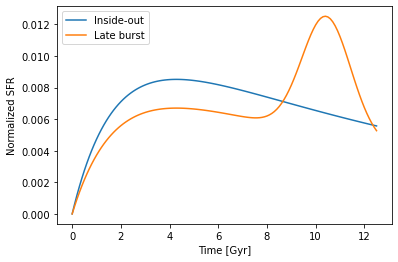

In [19]:
tarr = np.arange(0, 12.6, 0.1)
plt.plot(tarr, A_io * f_io(tarr) * g(8), label='Inside-out')
plt.plot(tarr, A_lb * f_lb(tarr) * g(8), label='Late burst')
plt.xlabel('Time [Gyr]')
plt.ylabel('Normalized SFR')
plt.legend()
plt.show()

In [14]:
# Mass-loading parameter function
ycc_o = vice.yields.ccsne.settings['o']
z_solar_o = vice.solar_z['o']

def eta(rgal, gradient=-0.08, mode4=0.3, recycling=0.4):
    """
    Mass-loading factor as function of galactic radius in kpc.
    mode4 : mode of stellar [alpha/H] at 4 kpc radius
    """
    # Set [alpha/H] at 8 kpc to be 0
    exp = -gradient * (rgal - 4) - mode4
    return (ycc_o / z_solar_o) * 10 ** exp + recycling - 1

In [15]:
# Set up model
mw = vice.milkyway(name='late_burst_test', N=2e5, zone_width=1.0)
hds = vice.toolkit.hydrodisk.hydrodiskstars(np.linspace(0, 20, 21), N=2e5, mode='diffusion')
mw.migration.stars = hds
mw.delay = 0.15 # Gyr
mw.RIa = 'plaw'
mw.mass_loading = eta
mw.mode = 'sfr'
mw.evolution = late_burst
mw.dt = 0.01

In [16]:
# Run model
simtime = np.linspace(0, 12.5, 1251)
mw.run(simtime, overwrite=True)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: stars
  warnings.warn("""\


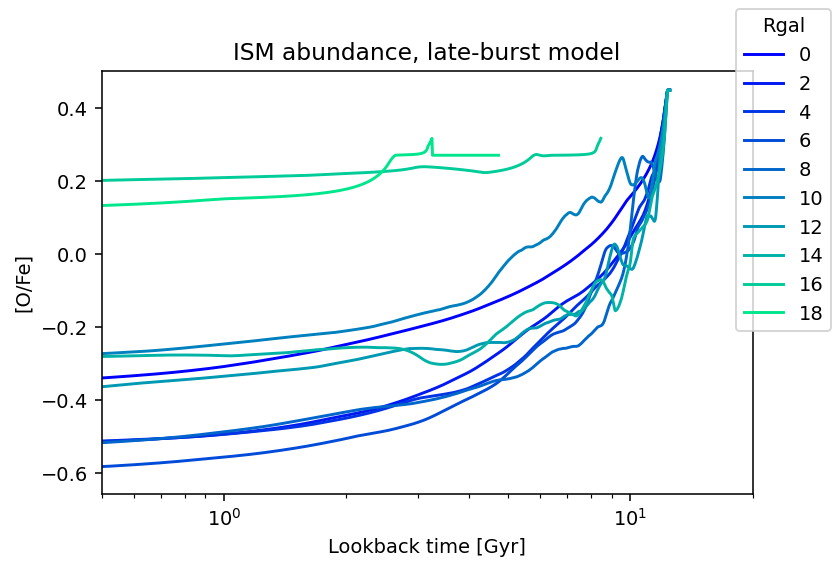

In [21]:
# Plot ISM abundance
fig, ax = plt.subplots(dpi=140)
cmap = cm.get_cmap('winter')
colors = [cmap(i/10) for i in range(10)]
out = vice.output('late_burst_test')
for zone in range(10):
    # Only plot every 2 zones
    hist = out.zones['zone%s' % (zone*2)].history
    ax.plot(np.array(hist['lookback']), hist['[o/fe]'], color=colors[zone], label=zone*2)
ax.set_xscale('log')
ax.set_xlim(0.5, 20)
ax.set_ylabel('[O/Fe]')
ax.set_xlabel('Lookback time [Gyr]')
ax.set_title('ISM abundance, late-burst model')
fig.legend(title='Rgal')
plt.savefig('late_burst_abundance.png')
plt.show()